Top Selected Features: ['user_rating_trend', 'user_avg_rating_before', 'user_previous_visits', 'attraction_avg_rating_before', 'attraction_previous_visitors', 'Region', 'VisitSeason']

Training XGBoost with top features...
XGBoost Performance:
R² Score: 0.8875455856323242
MAE: 0.15940967202186584
RMSE: 0.33171656787098885

Training GradientBoosting with top features...
GradientBoosting Performance:
R² Score: 0.8878396113390608
MAE: 0.17154405823105462
RMSE: 0.3312826735627388

Ensemble Average Prediction Performance:
R² Score: 0.8895814370203373
MAE: 0.163718543706924
RMSE: 0.3287002353486791


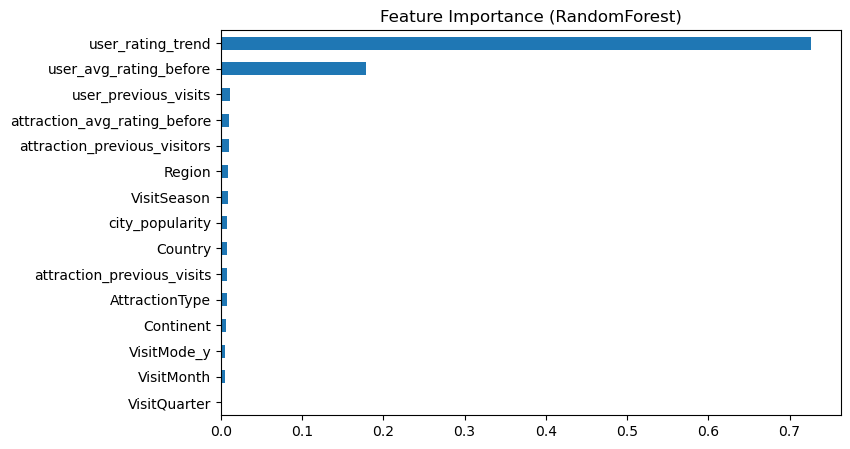

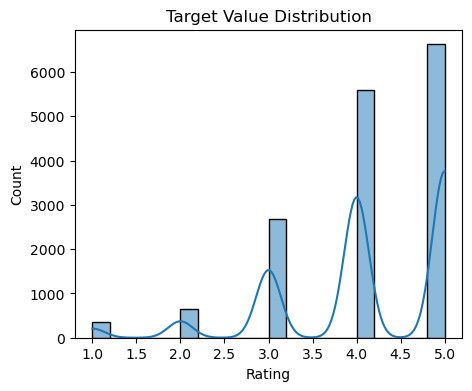

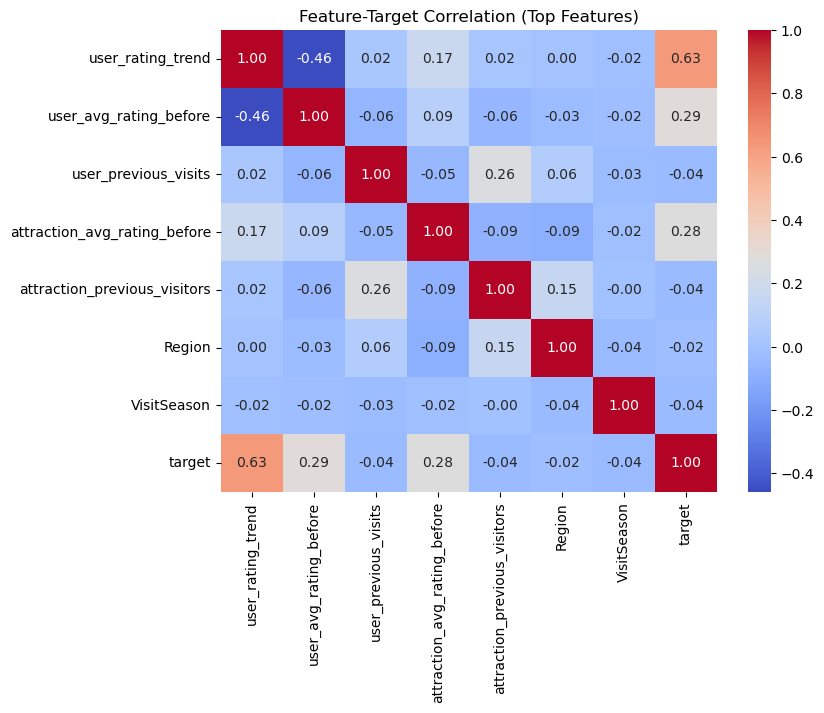

In [1]:
# =============================== Regression Model with Ensemble ===============================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# --- Load your data ---
df = pd.read_csv(r"C:\Users\C Sutharsan\Downloads\GUVI class notes AIML\Capstone_project\Project_4\Final\final_dataset.csv")
df = df.dropna()

# --- Features and target ---
features = [
    'VisitMonth', 'VisitQuarter', 'VisitMode_y', 'AttractionType', 
    'Continent', 'Region', 'Country', 'VisitSeason',
    'user_previous_visits', 'user_avg_rating_before', 'user_rating_trend',
    'attraction_previous_visits', 'attraction_avg_rating_before', 
    'attraction_previous_visitors', 'city_popularity'
]
target = 'Rating'

X = df[features].copy()
y = df[target]

# Identify categorical and numeric features
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

# --- Label encode categorical variables ---
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = X[col].fillna("missing")
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# --- Preprocessing pipeline for numeric features ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ],
    remainder='passthrough'  # keep encoded categorical features as-is
)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Models ---
models = {
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1, learning_rate=0.05),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, random_state=42, learning_rate=0.05)
}

# --- Feature selection using RandomForest (to choose top features) ---
xg_for_fs = XGBRegressor(n_estimators=200, random_state=42)
xg_for_fs.fit(X_train, y_train)
feature_importances = pd.Series(xg_for_fs.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(7).index.tolist()

print("Top Selected Features:", top_features)

# --- Evaluate all models using only top features ---
predictions = {}
for name, model in models.items():
    print(f"\nTraining {name} with top features...")
    model.fit(X_train[top_features], y_train)
    preds = model.predict(X_test[top_features])
    predictions[name] = preds
    print(f"{name} Performance:")
    print("R² Score:", r2_score(y_test, preds))
    print("MAE:", mean_absolute_error(y_test, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))

# --- Average prediction (Ensemble) ---
avg_preds = np.mean(list(predictions.values()), axis=0)
print("\nEnsemble Average Prediction Performance:")
print("R² Score:", r2_score(y_test, avg_preds))
print("MAE:", mean_absolute_error(y_test, avg_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, avg_preds)))

# --- Feature Importance Plot ---
plt.figure(figsize=(8,5))
feature_importances.sort_values().plot(kind='barh', title="Feature Importance (RandomForest)")
plt.show()

# --- Target distribution ---
plt.figure(figsize=(5,4))
sns.histplot(y, kde=True, bins=20)
plt.title("Target Value Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# --- Correlation matrix ---
numeric_X = X[top_features].copy()
numeric_X['target'] = y
corr_matrix = numeric_X.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature-Target Correlation (Top Features)")
plt.show()


In [3]:
import joblib

# Save individual models
for name, model in models.items():
    joblib.dump(model, f"{name}_model.pkl")

# Save the top features list
joblib.dump(top_features, "top_features.pkl")
# Save label encoders for later use in app
joblib.dump(label_encoders, "label_encoders.pkl")


# Save ensemble average predictions as a NumPy file (optional)
np.save("ensemble_avg_preds.npy", avg_preds)

print("Models and top features saved successfully.")


Models and top features saved successfully.
